# Evaluating synthetic data

In [1]:
import os
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance  # symetrics
from scipy.stats import entropy, norm
from sdmetrics.column_pairs import ContinuousKLDivergence, DiscreteKLDivergence
from sdmetrics.single_column import CSTest, KSTest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import recordlinkage
from sklearn.metrics.pairwise import cosine_distances
from sdmetrics.single_table import BNLikelihood, BNLogLikelihood, GMLogLikelihood


In [2]:
synth_data = pd.read_csv(
    "/Users/joaoalmeida/OneDrive/Pessoal/HEADS/05. TESE/2. dados sinteticos/testes/CTGAN/chedv_synth_restruct.csv",
    index_col=0,
)
real_data = pd.read_csv(
    "/Users/joaoalmeida/Desktop/tese_local/chedv/CHEDV_enviado_a_Joao_Almeida.csv",
    delimiter=";",
)

In [3]:
continuous_values = [
    "IMC",
    "IDADE_MATERNA",
    "PESO_INICIAL",
    "SEMANAS_GESTACAO_PARTO",
    "PESO_ADMISSAO_INTERNAMENTO",
    "IDADE_GESTACIONAL_ADMISSAO",
    "NUMERO_CONSULTAS_PRE_NATAL",
]
# categorical variables
categorical_values = real_data[real_data.columns.difference(continuous_values)].columns

In [4]:
def get_high_null(df):
    high_null_cols = []
    for column in df.columns:
        if df[column].isna().sum() / len(df) >= 0.8:
            # print(column,categoricaldf[column].isna().sum()/7743)
            high_null_cols.append(column)
    return high_null_cols


high_null = get_high_null(real_data)
real_data.drop(columns=high_null, inplace=True)

In [5]:
real_data = real_data[synth_data.columns]
synth_data = synth_data[real_data.columns]

In [6]:
continuous_values=[col for col in continuous_values if col in real_data.columns]
categorical_values=[col for col in categorical_values if col in real_data.columns]


In [7]:
###########################
#####REPORT VARIABLES######
###########################
def guess_categorical(df,categorical_values):

    return pd.DataFrame({"Columns":categorical_values,"Type":["Categorical"]*len(categorical_values)})
    
def create_df_dtypes(df):
    result={}
    for column in df.columns:
        result[column]=str(df[column].dtypes)
    return result
    
col_types=pd.DataFrame.from_dict(create_df_dtypes(synth_data),orient="index").reset_index()
col_types.rename(columns={"index":"Columns",0:"dtypes"},inplace=True)
categorical_col_df=guess_categorical(synth_data,categorical_values)
col_list_df=col_types.merge(categorical_col_df,how="left",on="Columns")
col_list_df.fillna(value="Continuous",inplace=True)#the remaining are continuous
col_list_df.iloc[19,2]="Categorical" #corrections of G_TERAPEUTICA
col_list_df.loc[0,"Type"]="Continuous"#corrections of IDADE_MATERNA
col_list_lt_df = col_list_df.to_latex(index=False, na_rep="N", longtable=True,label="tab:desc",caption="Dataset Variables Description")


synth_null=pd.DataFrame(synth_data.loc[:, synth_data.isna().sum() > 0].isna().sum()).reset_index()
real_null=pd.DataFrame(real_data.loc[:, real_data.isna().sum() > 0].isna().sum()).reset_index()
df_columns=pd.DataFrame({"Columns":real_data.columns.tolist()})
null_total = df_columns.merge( real_null, left_on="Columns",right_on="index",how="left")
null_total_df=null_total.merge(synth_null,left_on="Columns",right_on="index",how="left")


describe_cols=["mean","std","25%","50%","75%"]
synth_data_describe=synth_data.describe().transpose().to_latex(float_format="%.1f",na_rep="Null",longtable=True,caption="Synthetic Data Description",label="tab:synthdatadesc",columns=describe_cols)
real_data_describe=real_data.describe().transpose().to_latex(float_format="%.1f",na_rep="Null",longtable=True,caption="Original Data Description",label="tab:realdatadesc",columns=describe_cols)
null_total_df_lt=null_total_df.to_latex(index=False,na_rep="0",longtable=True,caption="Null values Comparison",label="tab:nullcomparison",columns=["Columns","0_x","0_y"],header=["Column","Real","Synthetic"])

In [8]:
removed_cols= real_data[real_data.columns.difference(synth_data.columns)].columns.to_list()

In [9]:
len(synth_data.columns) == len(real_data.columns)
print(len(synth_data.columns),len(real_data.columns)
)

51 51


In [10]:
synth_data.loc[:, synth_data.isna().sum() > 0].isna().sum()

GS                          38
TIPO_GRAVIDEZ             1171
VIGIADA                     40
VIGIADA_HOSPITAL          3428
VIGIADA_CENTRO_SAUDE      2435
VIGIADA_NESTE_HOSPITAL     987
G_TERAPEUTICA             1179
BACIA                     6574
COVID_19                  1556
RETESTE_NEGATIVO          1042
dtype: int64

In [11]:
real_data.loc[:, real_data.isna().sum() > 0].isna().sum()

GS                              19
PESO_INICIAL                  1226
IMC                           1571
A_PARA                         667
TIPO_GRAVIDEZ                  698
VIGIADA                          4
NUMERO_CONSULTAS_PRE_NATAL    1714
VIGIADA_HOSPITAL              1885
VIGIADA_CENTRO_SAUDE          3624
VIGIADA_NESTE_HOSPITAL        1964
G_TERAPEUTICA                 1555
BACIA                         5932
BISHOP_SCORE                  6129
IDADE_GESTACIONAL_ADMISSAO      42
SEMANAS_GESTACAO_PARTO          10
COVID_19                       935
RETESTE_NEGATIVO              1278
dtype: int64

In [12]:
synth_data.head(1)

IDADE_MATERNA             GS  PESO_INICIAL   IMC CIGARROS ALCOOL  \
0           37.0  A,RH_POSITIVO          62.0  23.5      NAO    NAO   

  ESTUPEFACIENTES  A_PARA  A_GESTA  EUTOCITO_ANTERIOR  ...        CARDIACA  \
0             NAO     1.0      2.0                0.0  ...  NAO_PREENCHIDO   

   TIPO_PARTO  APRESENTACAO_NO_PARTO TRAB_PARTO_NO_PARTO  \
0   Cesariana               Cefálica             Indução   

  SEMANAS_GESTACAO_PARTO  GRUPO_ROBSON DATA_PARTO_mes DATA_PARTO_ano  \
0                  272.0             2            1.0         2018.0   

        COVID_19 RETESTE_NEGATIVO  
0  NAO_APLICAVEL    NAO_APLICAVEL  

[1 rows x 51 columns]

In [13]:
synth_data.describe()

IDADE_MATERNA  PESO_INICIAL          IMC       A_PARA      A_GESTA  \
count    7743.000000   7743.000000  7743.000000  7743.000000  7743.000000   
mean       33.947307     60.662146    22.360920     1.006587     1.462999   
std         6.052198      8.052978     2.766971     0.968148     1.731273   
min        21.000000     28.000000    11.600000     0.000000     0.000000   
25%        30.000000     57.000000    20.500000     1.000000     0.000000   
50%        32.000000     62.000000    23.400000     1.000000     1.000000   
75%        40.000000     64.000000    23.600000     1.000000     3.000000   
max        47.000000    111.000000    35.800000     8.000000    17.000000   

       EUTOCITO_ANTERIOR  VENTOSAS_ANTERIOR  FORCEPS_ANTERIOR  \
count        7743.000000        7743.000000       7743.000000   
mean            0.401007           0.087950          0.016531   
std             0.918809           0.309395          0.127514   
min             0.000000           0.000000          0.000000   
25%             0.000000           0.000000          0.000000   
50%             0.000000           0.000000          0.000000   
75%             0.000000           0.000000          0.000000   
max             8.000000           2.000000          1.000000   

       CESARIANAS_ANTERIOR  NUMERO_CONSULTAS_PRE_NATAL       NUM_RN  \
count          7743.000000                 7743.000000  7743.000000   
mean              0.176676                   10.197727     1.029833   
std               0.488872                    7.777870     0.183295   
min               0.000000                    1.000000     1.000000   
25%               0.000000                    4.000000     1.000000   
50%               0.000000                    8.000000     1.000000   
75%               0.000000                   17.000000     1.000000   
max               4.000000                   46.000000     3.000000   

       BISHOP_SCORE  IDADE_GESTACIONAL_ADMISSAO  SEMANAS_GESTACAO_PARTO  \
count    7743.00000                 7743.000000             7743.000000   
mean        4.24280                   38.900840              267.152912   
std         1.64851                    1.393375               18.891863   
min         0.00000                   28.740318              138.000000   
25%         4.00000                   38.462045              267.000000   
50%         4.00000                   39.293927              270.000000   
75%         4.00000                   39.491532              278.000000   
max        13.00000                   41.358827              288.000000   

       DATA_PARTO_mes  DATA_PARTO_ano  
count     7743.000000     7743.000000  
mean         6.789746     2018.084334  
std          3.268800        1.634677  
min          1.000000     2015.000000  
25%          4.000000     2017.000000  
50%          7.000000     2018.000000  
75%         10.000000     2020.000000  
max         12.000000     2020.000000

In [14]:
real_data.head(1)

IDADE_MATERNA             GS  PESO_INICIAL   IMC CIGARROS ALCOOL  \
0             27  O,RH_POSITIVO          56.0  23.0      SIM    NAO   

  ESTUPEFACIENTES  A_PARA  A_GESTA  EUTOCITO_ANTERIOR  ...        CARDIACA  \
0             NAO     0.0        0                  0  ...  NAO_PREENCHIDO   

   TIPO_PARTO  APRESENTACAO_NO_PARTO            TRAB_PARTO_NO_PARTO  \
0   Cesariana               Cefálica  Ausência de trabalho de parto   

  SEMANAS_GESTACAO_PARTO  GRUPO_ROBSON DATA_PARTO_mes DATA_PARTO_ano  \
0                  281.0             2             10           2020   

   COVID_19 RETESTE_NEGATIVO  
0  Positivo    NAO_REALIZADO  

[1 rows x 51 columns]

In [15]:
real_data.describe()

IDADE_MATERNA  PESO_INICIAL          IMC       A_PARA      A_GESTA  \
count    7743.000000   6517.000000  6172.000000  7076.000000  7743.000000   
mean       30.634121     65.595596    24.982226     0.701809     1.423479   
std         5.657156     13.271360     6.248120     0.800778     1.463162   
min        14.000000     32.000000    14.500000     0.000000     0.000000   
25%        27.000000     56.000000    21.500000     0.000000     0.000000   
50%        31.000000     63.000000    23.900000     1.000000     2.000000   
75%        35.000000     73.000000    27.300000     1.000000     2.000000   
max        49.000000    169.000000   202.900000     8.000000    17.000000   

       EUTOCITO_ANTERIOR  VENTOSAS_ANTERIOR  FORCEPS_ANTERIOR  \
count        7743.000000        7743.000000       7743.000000   
mean            0.409015           0.062896          0.010332   
std             0.709719           0.249611          0.101126   
min             0.000000           0.000000          0.000000   
25%             0.000000           0.000000          0.000000   
50%             0.000000           0.000000          0.000000   
75%             1.000000           0.000000          0.000000   
max             8.000000           2.000000          1.000000   

       CESARIANAS_ANTERIOR  NUMERO_CONSULTAS_PRE_NATAL       NUM_RN  \
count          7743.000000                 6029.000000  7743.000000   
mean              0.153816                    6.347487     1.015110   
std               0.407214                    5.365583     0.123054   
min               0.000000                    0.000000     1.000000   
25%               0.000000                    2.000000     1.000000   
50%               0.000000                    4.000000     1.000000   
75%               0.000000                    9.000000     1.000000   
max               4.000000                   41.000000     3.000000   

       BISHOP_SCORE  IDADE_GESTACIONAL_ADMISSAO  SEMANAS_GESTACAO_PARTO  \
count   1614.000000                 7701.000000             7733.000000   
mean       4.872367                   38.932372              273.923057   
std        3.059820                    1.914427               12.599327   
min        0.000000                   22.400000              161.000000   
25%        3.000000                   38.400000              270.000000   
50%        4.000000                   39.300000              276.000000   
75%        7.000000                   40.100000              281.000000   
max       13.000000                   43.400000              299.000000   

       DATA_PARTO_mes  DATA_PARTO_ano  
count     7743.000000     7743.000000  
mean         6.653235     2017.807310  
std          3.341726        1.503226  
min          1.000000     2015.000000  
25%          4.000000     2017.000000  
50%          7.000000     2018.000000  
75%         10.000000     2019.000000  
max         12.000000     2020.000000

In [16]:
def compare_datasets(real, synth):
    if len(real.columns) != len(synth.columns):
        print("number of columns different")

    missing_synth = []
    for real_col in real.columns:
        if real_col not in synth.columns:
            missing_synth.append(real_col)
    if len(missing_synth) > 0:
        print(
            f"{len(missing_synth)} columns from real dataset not in synth: {' , '.join(missing_synth)}"
        )

    missing_real = []
    for synth_col in synth.columns:
        if synth_col not in real.columns:
            missing_real.append(synth_col)
    if len(missing_real) > 0:
        print(
            f"{len(missing_real)} columns from synthetic dataset not in real: {' , '.join(missing_real)}"
        )

    real_types = real.dtypes
    real_col = real.columns
    real_col_type = []
    for t in range(0, len(real_types)):
        real_col_type.append(str(real_col[t]) + "|" + str(real_types[t]))

    s_types = synth.dtypes
    s_col = synth.columns
    synth_col_type = []
    for t in range(0, len(s_types)):
        synth_col_type.append(str(s_col[t]) + "|" + str(s_types[t]))

    print([col for col in real_col_type if col not in synth_col_type])

In [17]:
# check for data
# columns no in col
compare_datasets(real_data, synth_data)

['IDADE_MATERNA|int64', 'A_GESTA|int64', 'EUTOCITO_ANTERIOR|int64', 'VENTOSAS_ANTERIOR|int64', 'FORCEPS_ANTERIOR|int64', 'CESARIANAS_ANTERIOR|int64', 'NUM_RN|int64', 'DATA_PARTO_mes|int64', 'DATA_PARTO_ano|int64']


No differences dectected between datasets

In [18]:
# convert types
real_data[real_data.select_dtypes("int64").columns] = real_data.select_dtypes(
    "int64"
).astype("float64")

In [19]:
###########################
#####REPORT VARIABLES######
###########################

describe_cols = ["mean", "std", "25%", "50%", "75%"]
synth_data_describe = (
    synth_data.describe()
    .transpose()
    .to_latex(
        float_format="%.1f",
        na_rep="Null",
        longtable=True,
        caption="Synthetic Data Description",
        label="Synth data desc",
        columns=describe_cols,
    )
)
real_data_describe = (
    real_data.describe()
    .transpose()
    .to_latex(
        float_format="%.1f",
        na_rep="Null",
        longtable=True,
        caption="Original Data Description",
        label="Realdatadesc",
        columns=describe_cols,
    )
)

## 1. Utility
### 1.1 Visual analysis

In [20]:
concatenated = pd.concat(
    [real_data.assign(dataset="real"), synth_data.assign(dataset="synth")]
).reset_index()

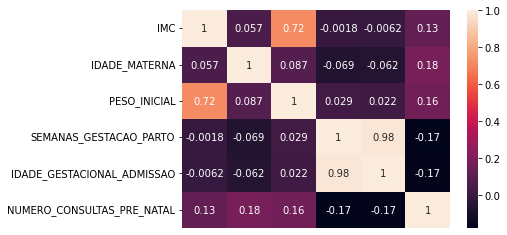

In [21]:
sns_plot = sns.heatmap(real_data[continuous_values].corr(),annot=True, xticklabels=False)
sns_plot.figure.savefig("images/heatmap_real.png",transparent=True, bbox_inches='tight')
sns_plot;

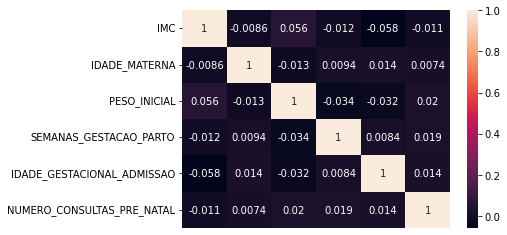

In [22]:
sns_plot = sns.heatmap(synth_data[continuous_values].corr(),annot=True, xticklabels=False)
figheatmap=sns_plot.figure
figheatmap.savefig("images/heatmap_synth.png",transparent=True, bbox_inches='tight')
sns_plot;

5
GS
A_PARA
A_GESTA
EUTOCITO_ANTERIOR
TIPO_GRAVIDEZ
G_TERAPEUTICA
BISHOP_SCORE
GRUPO_ROBSON
DATA_PARTO_mes


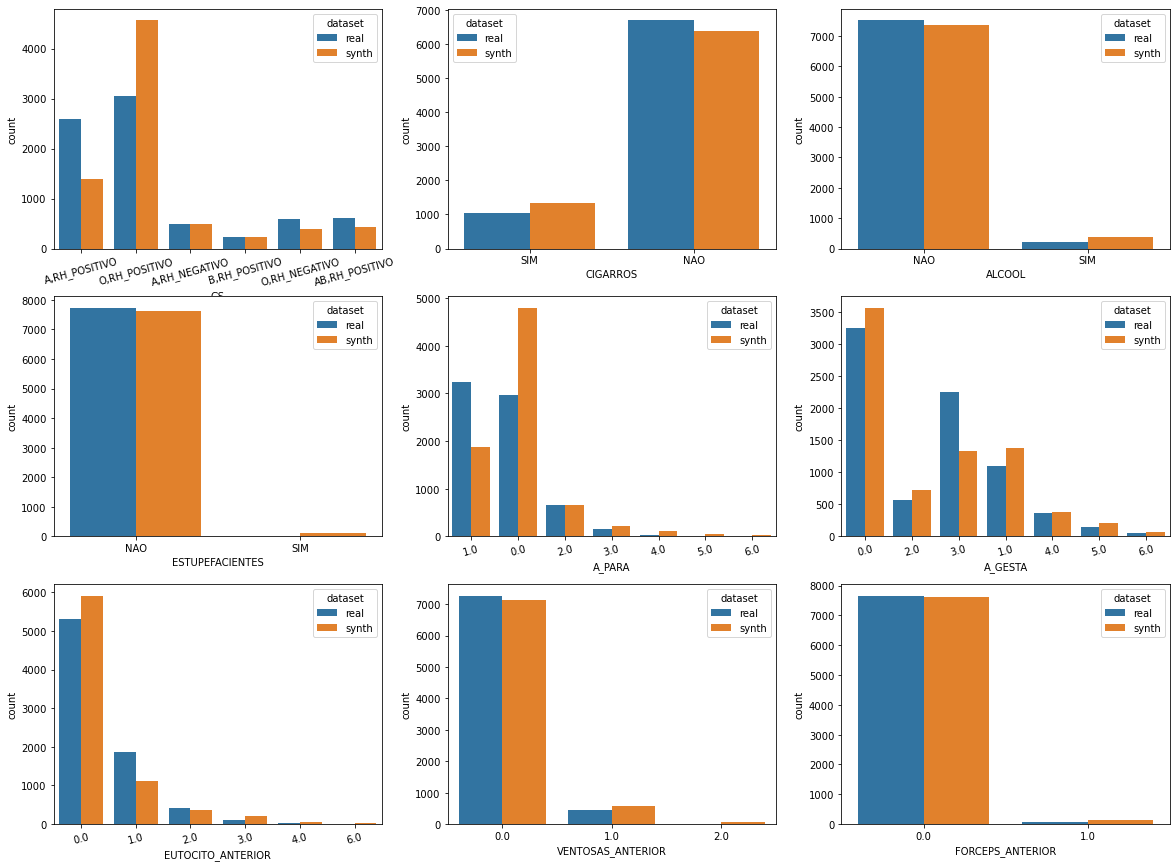

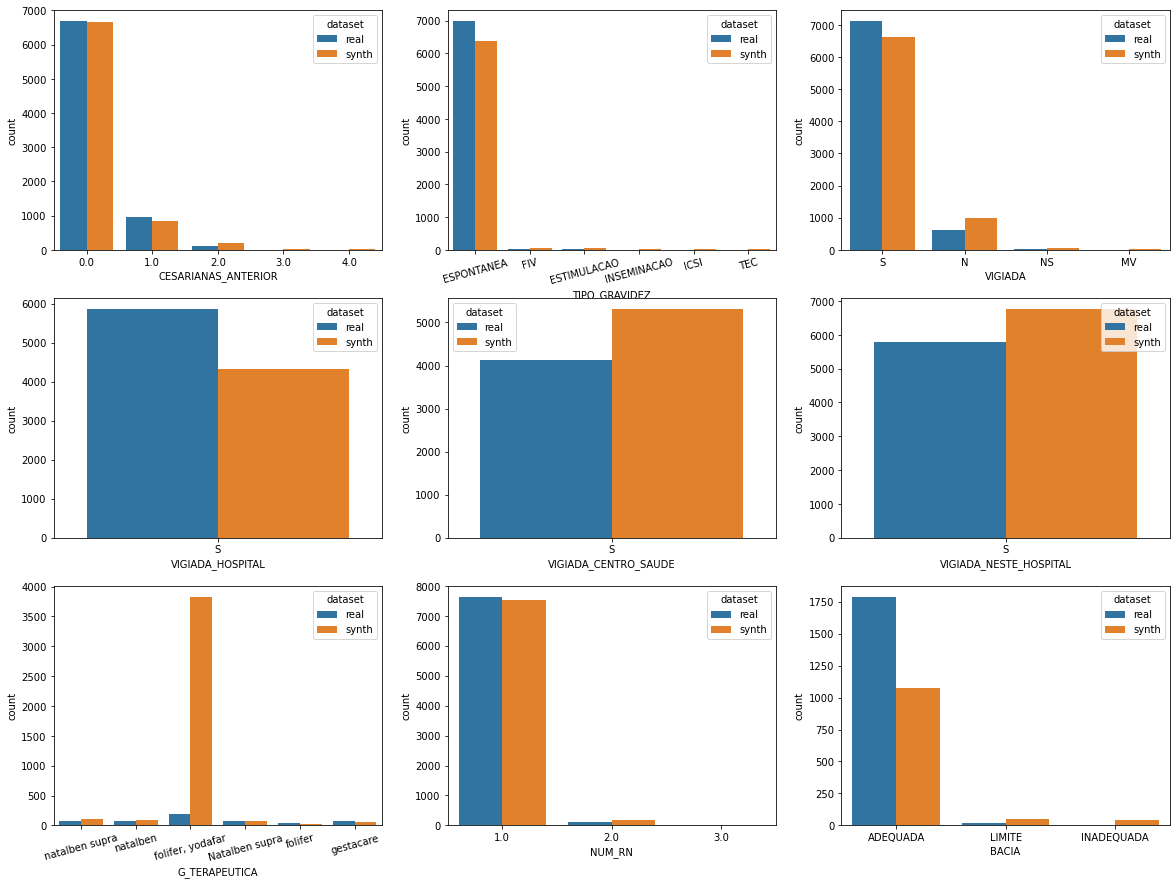

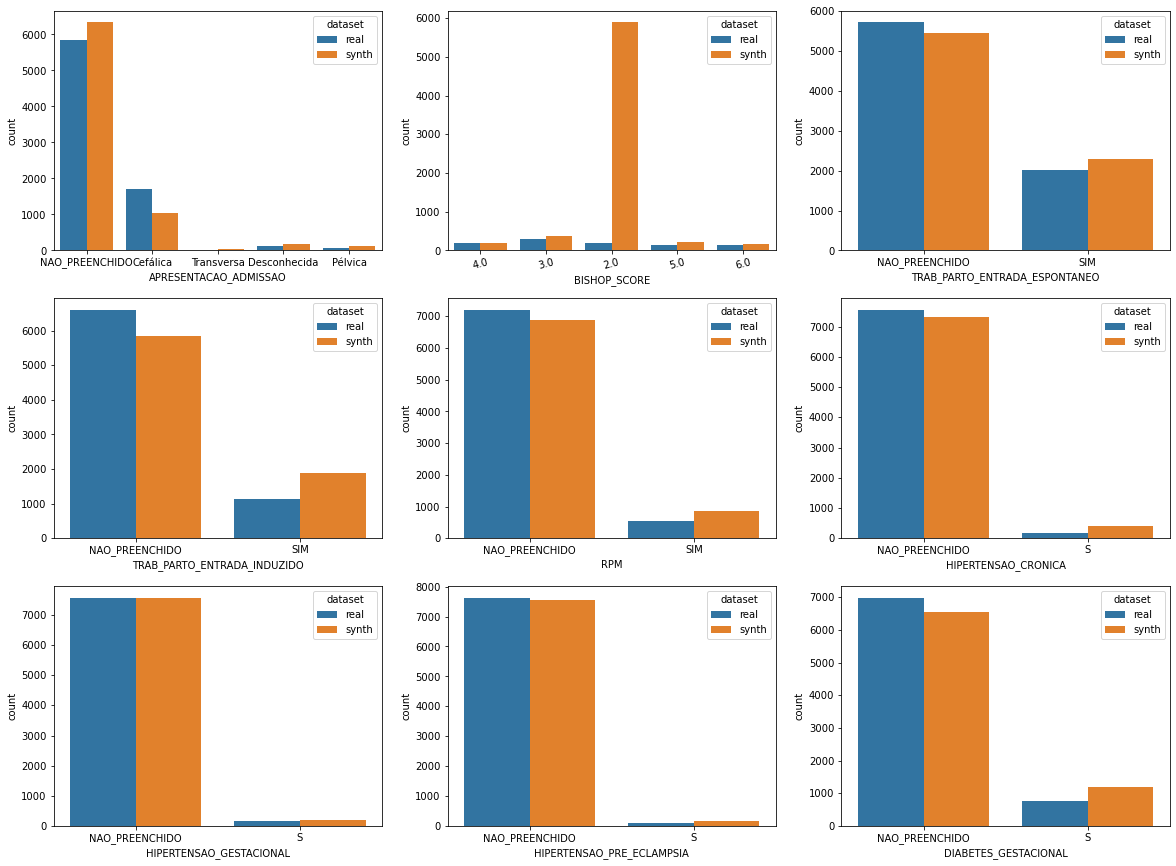

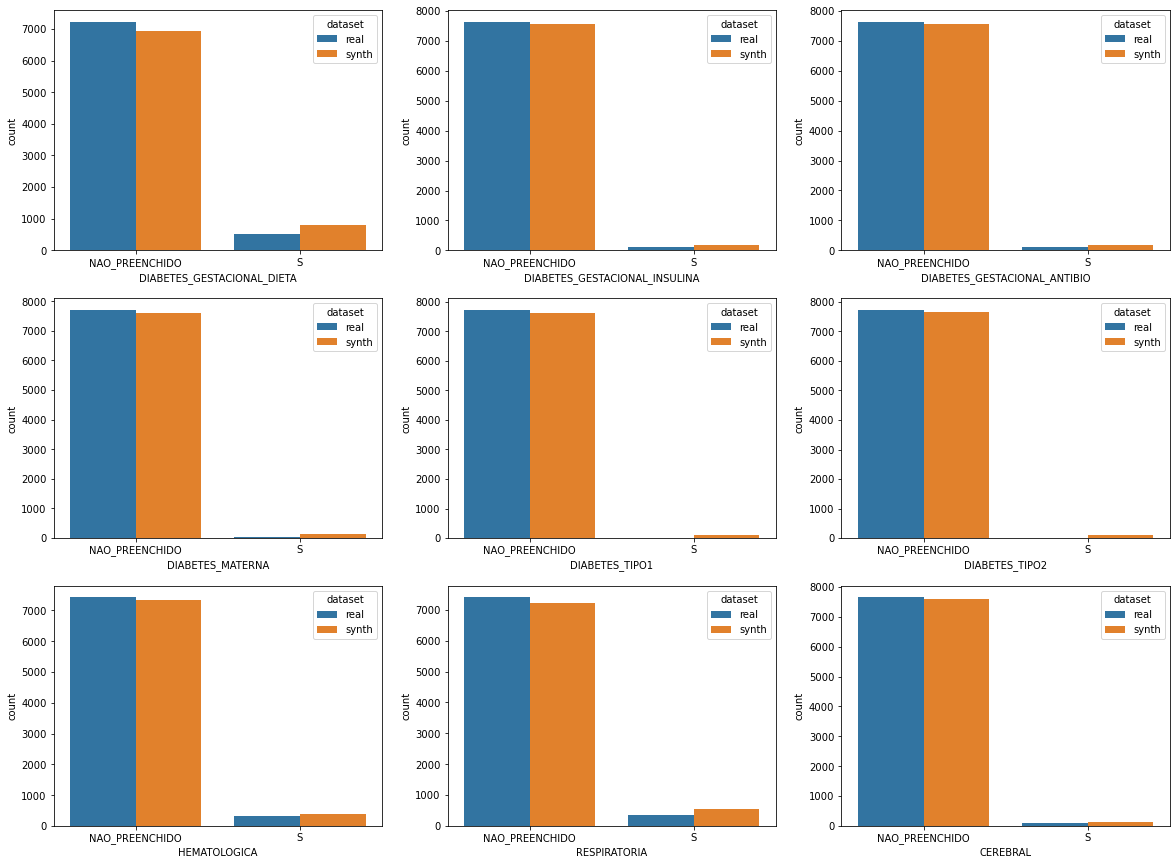

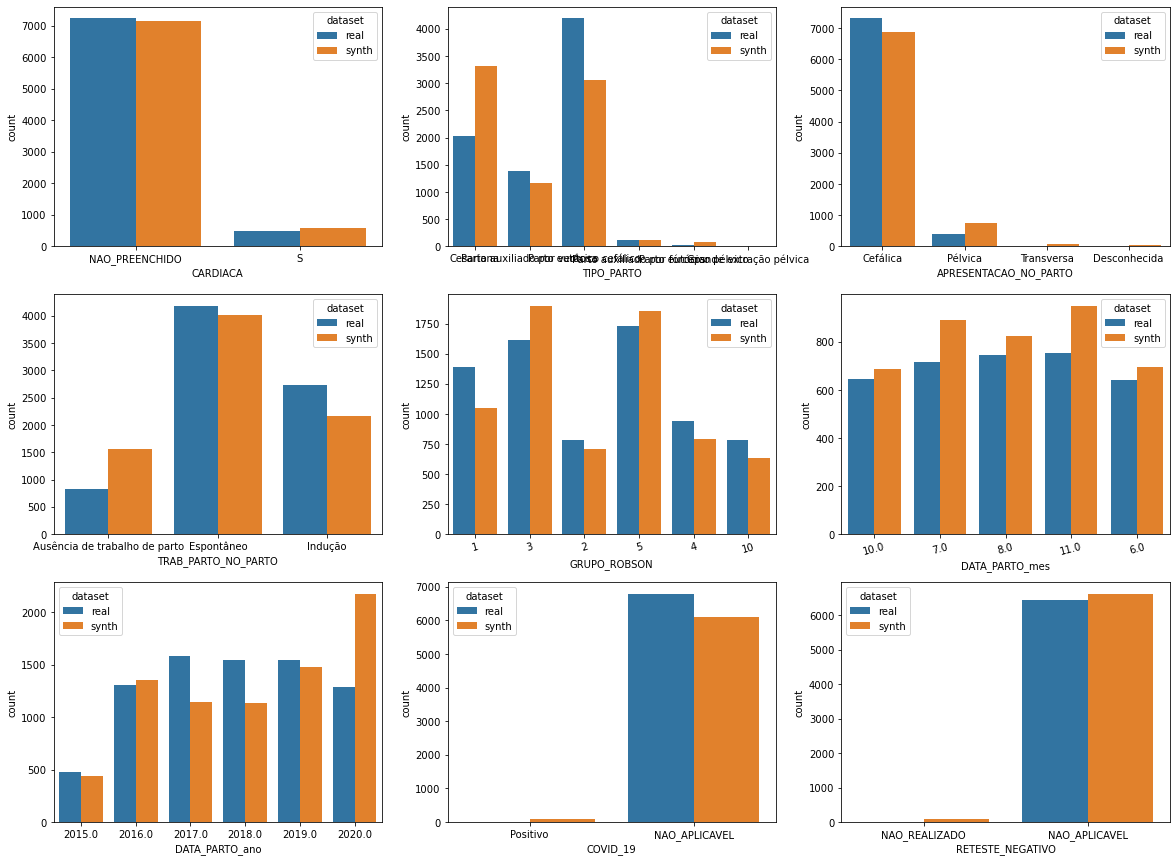

In [23]:
def plot_categorical(df, categorical_columns=[], nrow=2, ncol=2, figw=20, figh=10,name="categorical_plot.png"):
    nr = len(categorical_columns)
    if nr == 0:
        categorical_columns = df.select_dtypes("object").columns
    f, axs = plt.subplots(nrow, ncol, figsize=(figw, figh))
    for idx, col in enumerate(categorical_columns):
        if len(df[col].unique()) < 7:
            sns_cat_plot = sns.countplot(
                x=col, data=df, hue="dataset", ax=axs[idx // ncol, idx % ncol]
            )
        else:
            print(col)
            most_cols=concatenated[col].value_counts()[:6].index.tolist()
            dfmost=df[df[col].isin(most_cols)]
            sns_cat_plot=sns.countplot(
            x=col, data=dfmost, hue="dataset",ax=axs[idx // ncol, idx % ncol])
            sns_cat_plot.set_xticklabels(labels=most_cols, rotation=15)
    sns_cat_plot.figure.savefig("images/"+name)
  #  sns_cat_plot

categorical_cols=col_list_df[col_list_df["Type"]=="Categorical"]["Columns"].to_list()
nbr=len(categorical_cols)//9
print(nbr)

for i in range(0,nbr):
    plot_categorical(
    concatenated,
    categorical_cols[i*9:i*9+9],
    nrow=3,
    ncol=3,
    figh=15,name="categorical_plot_"+str(i)+".png"
)

1
6
IDADE_MATERNA 0 0
PESO_INICIAL 0 1
IMC 0 2
NUMERO_CONSULTAS_PRE_NATAL 1 0
IDADE_GESTACIONAL_ADMISSAO 1 1
SEMANAS_GESTACAO_PARTO 1 2


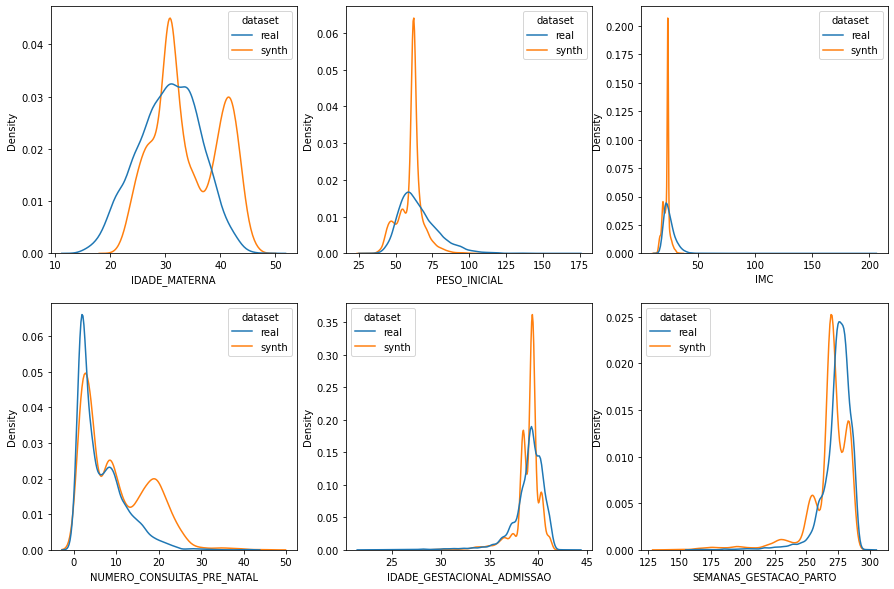

In [25]:
def plot_numerical(df, num_columns=[], nrow=2, ncol=2, figw=15, figh=10,name="continuous_plot.png"):
    
    nr = len(num_columns)
    print(nr)
    if nr == 0:
        num_columns = df.select_dtypes("float").columns
    f, axs = plt.subplots(nrow, ncol, figsize=(figw, figh))
    for idx, col in enumerate(num_columns):
        print(col,idx // ncol, idx % ncol)
        sns_kde_plot = sns.kdeplot(
            data=df, x=col, hue="dataset", ax=axs[idx // ncol, idx % ncol]
        )
    sns_kde_plot.figure.savefig("images/"+name)
    sns_kde_plot

continuous_cols=col_list_df[col_list_df["Type"]=="Continuous"]["Columns"].to_list()
nbr=len(continuous_cols)//6
print(nbr)

for i in range(0,nbr):
    plot_numerical(
    concatenated,
    continuous_cols[i*6:i*6+6],
    nrow=2,
    ncol=3,
    figw=15,name="continuous_plot_"+str(i)+".png"
)

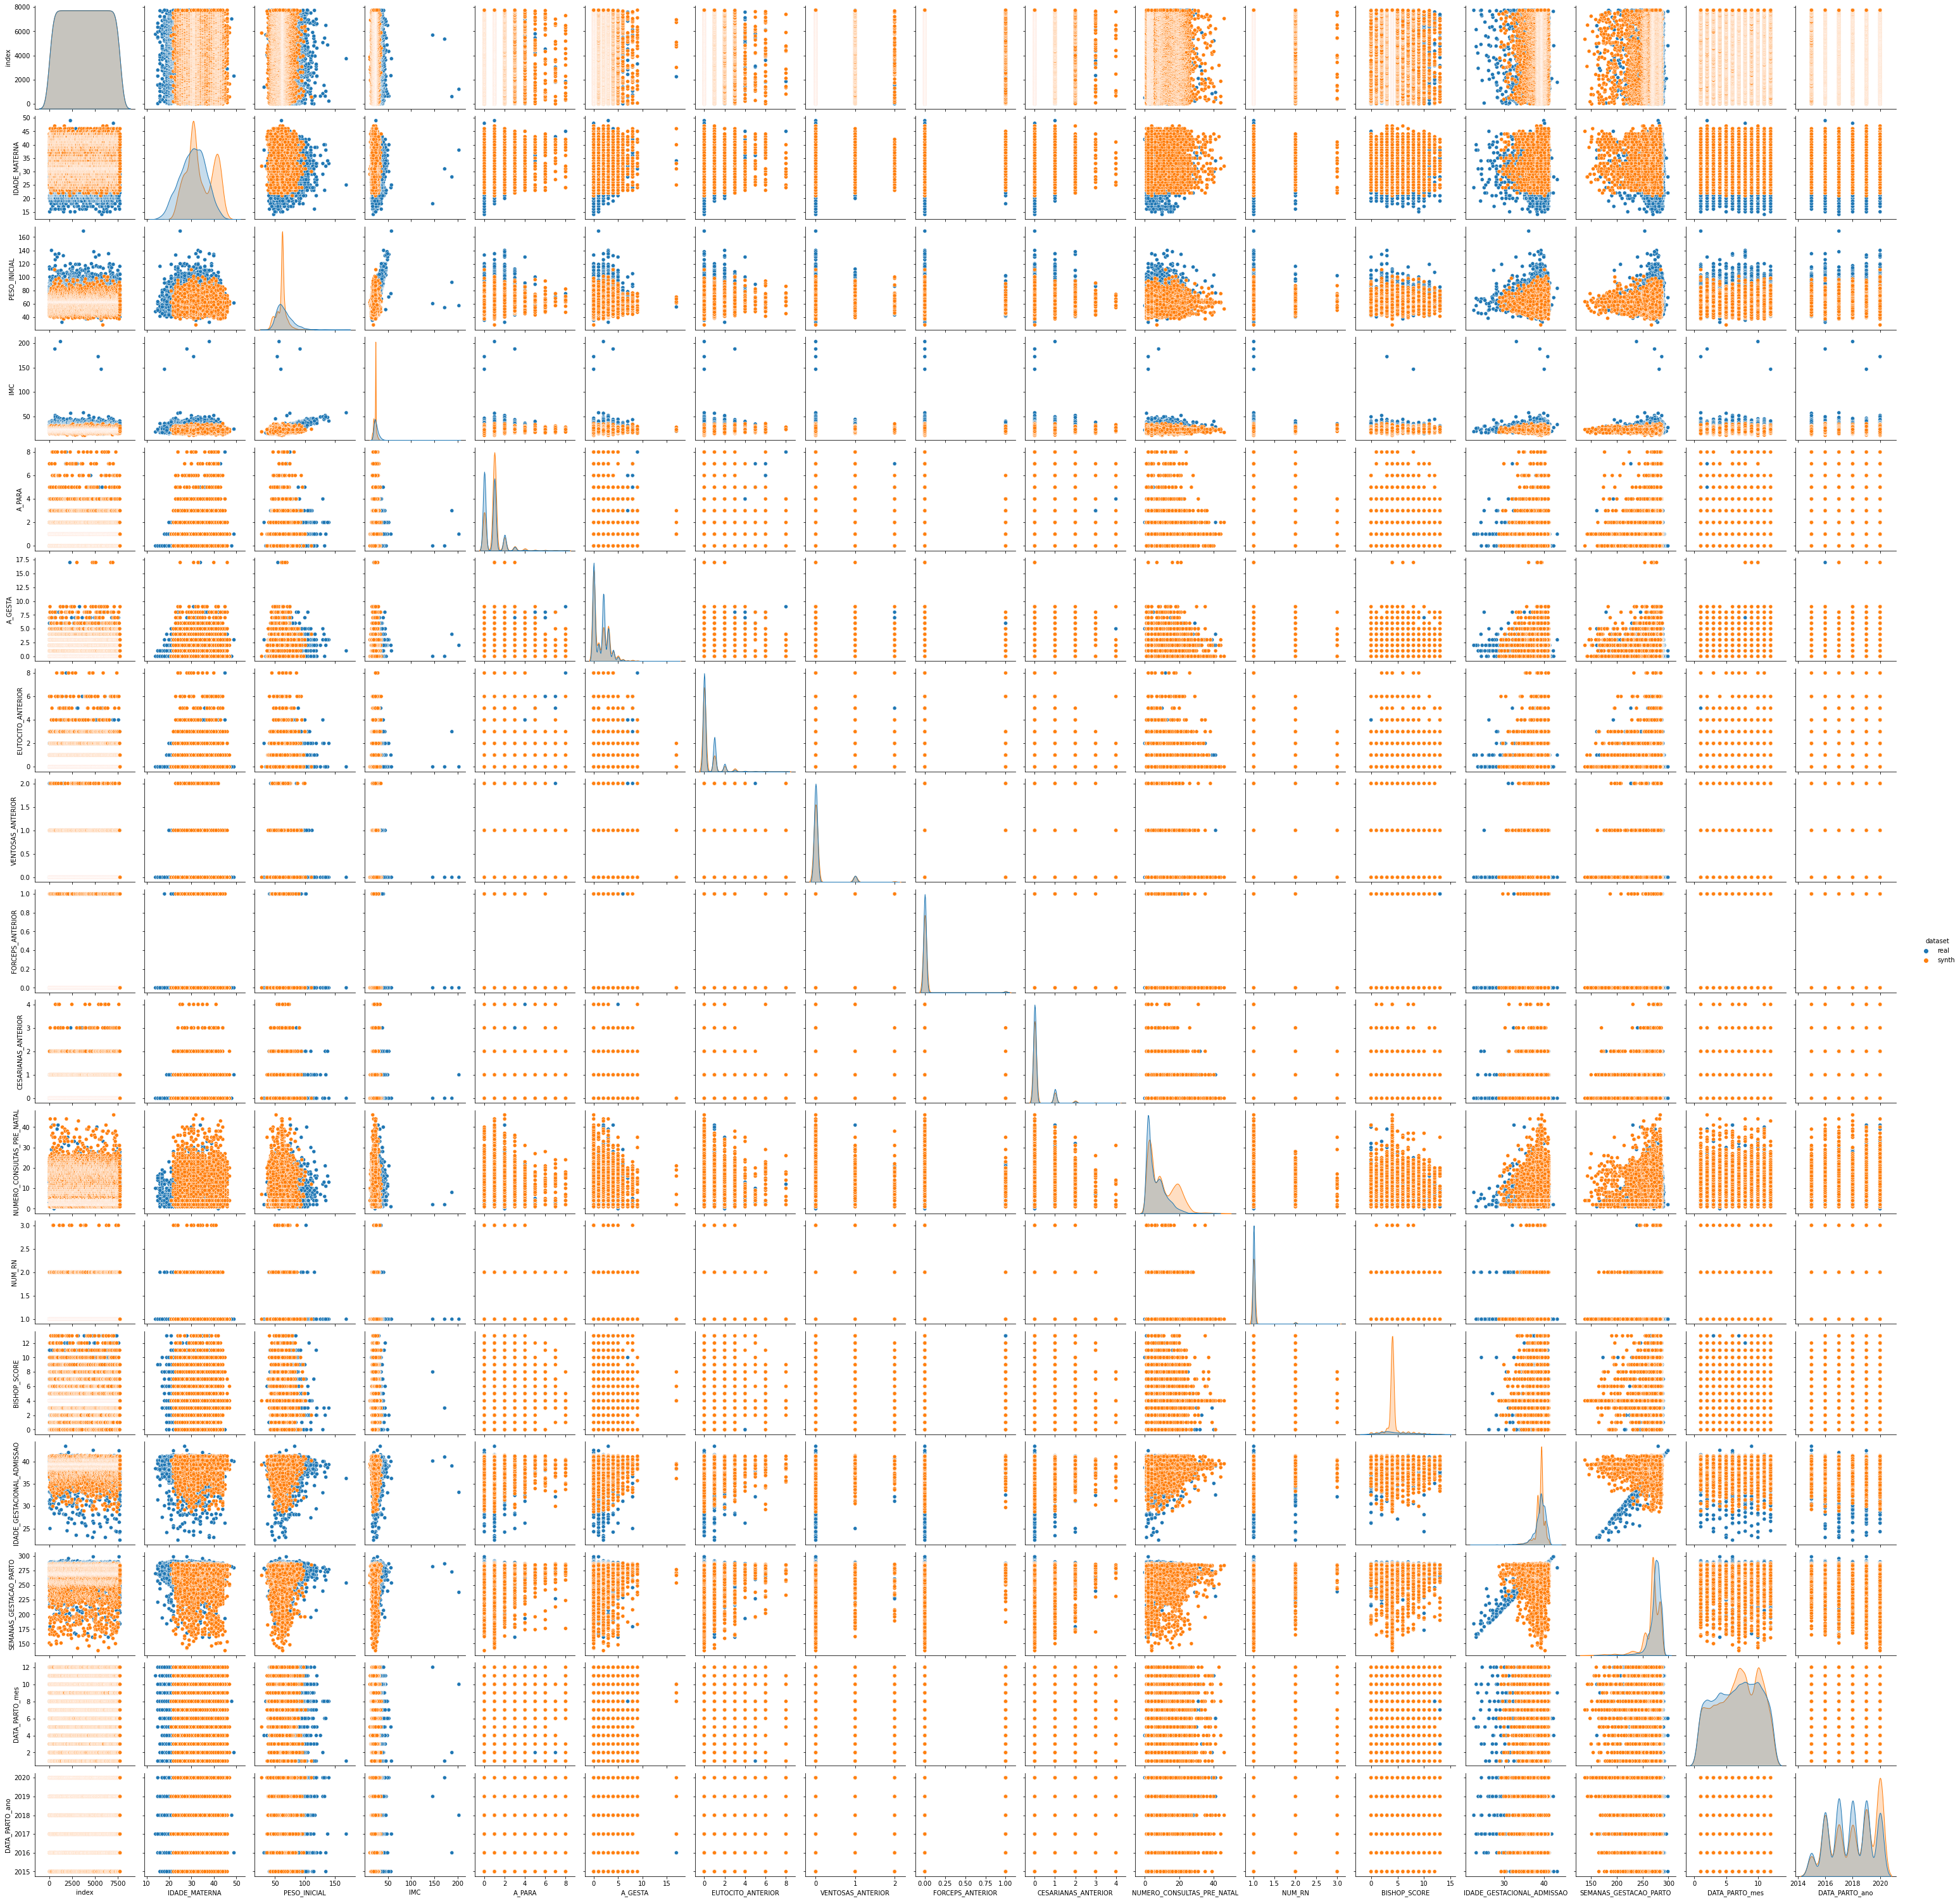

In [26]:
pairplot=sns.pairplot(concatenated, hue="dataset");

In [27]:
pairplot.savefig("images/pairplot.png")

### 1.2 Quantitative Analysis

#### 1.2.1 Columnwise 

In [28]:
def kstest_cols(real, synth, cols):  # for continuous
    """
    As a result, the output value is 1.0 if the distributions are identical and 0.0 if they are completely different.
    
    """
    result = {}
    for col in cols:
        result[col] = KSTest.compute(real[col], synth[col])
    return result

In [29]:
ks_test_df=pd.DataFrame.from_dict(kstest_cols(
    real_data,
    synth_data,
  continuous_values,
),orient='index',columns=["KS Test"])
ks_test_df

KS Test
IMC                         0.747385
IDADE_MATERNA               0.767015
PESO_INICIAL                0.811184
SEMANAS_GESTACAO_PARTO      0.663050
IDADE_GESTACIONAL_ADMISSAO  0.803177
NUMERO_CONSULTAS_PRE_NATAL  0.685393

In [30]:
def cstest_cols(real, synth, cols):  # for categorical
    """
    p value that we can reject null hypothesis, that the distributions are different,higher p, similar chance

    """
    result = {}
    for col in cols:
        result[col] = CSTest.compute(real[col], synth[col])
    return result

In [31]:
cs_test_df=pd.DataFrame.from_dict(cstest_cols(real_data, synth_data, categorical_values),orient='index',columns=["chi-squared"])
cs_test_df

chi-squared
ALCOOL                            0.894488
APRESENTACAO_ADMISSAO             0.999543
APRESENTACAO_NO_PARTO             0.988062
A_GESTA                           1.000000
A_PARA                            1.000000
BACIA                             0.990760
BISHOP_SCORE                      1.000000
CARDIACA                          0.964088
CEREBRAL                          0.966135
CESARIANAS_ANTERIOR               0.999844
CIGARROS                          0.905551
COVID_19                          0.936540
DATA_PARTO_ano                    0.999800
DATA_PARTO_mes                    1.000000
DIABETES_GESTACIONAL              0.849627
DIABETES_GESTACIONAL_ANTIBIO      0.944433
DIABETES_GESTACIONAL_DIETA        0.885633
DIABETES_GESTACIONAL_INSULINA     0.933256
DIABETES_MATERNA                  0.819381
DIABETES_TIPO1                    0.708412
DIABETES_TIPO2                    0.730155
ESTUPEFACIENTES                   0.750131
EUTOCITO_ANTERIOR                 0.999996
FORCEPS_ANTERIOR                  0.951116
GRUPO_ROBSON                      1.000000
GS                                1.000000
G_TERAPEUTICA                     1.000000
HEMATOLOGICA                      0.962850
HIPERTENSAO_CRONICA               0.847631
HIPERTENSAO_GESTACIONAL           0.985937
HIPERTENSAO_PRE_ECLAMPSIA         0.937960
NUM_RN                            0.977912
RESPIRATORIA                      0.904966
RETESTE_NEGATIVO                  0.978033
RPM                               0.873178
TIPO_GRAVIDEZ                     0.999985
TIPO_PARTO                        0.999438
TRAB_PARTO_ENTRADA_ESPONTANEO     0.934336
TRAB_PARTO_ENTRADA_INDUZIDO       0.782306
TRAB_PARTO_NO_PARTO               0.950206
VENTOSAS_ANTERIOR                 0.987513
VIGIADA                           0.997026
VIGIADA_CENTRO_SAUDE              0.758276
VIGIADA_HOSPITAL                  0.642405
VIGIADA_NESTE_HOSPITAL            0.771817

In [32]:
def categorical_to_prob_dist_v2(realcol, synthcol, factor=1e-6):
    """
    calculates 
    """
    real_prob = realcol.value_counts() / len(realcol)
    synth_prob = synthcol.value_counts() / len(synthcol)
    concate = pd.concat([real_prob, synth_prob], axis=1).fillna(
        factor
    )  # factor for not returning nan that will return error further down
    concate.columns = ["real", "synth"]
    return np.array(concate.loc[:, "real"]), np.array(concate.loc[:, "synth"])

In [33]:
real_a, synth_a = categorical_to_prob_dist_v2(
    real_data["G_TERAPEUTICA"], synth_data["G_TERAPEUTICA"]
)

In [34]:
# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b):
    """
The KL divergence between a normal distribution with a mean of 0 and a standard deviation of 2
and another distribution with a mean of 2 and a standard deviation of 2 is equal to 500.
"""
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


KL(real_a, synth_a)  # they have to have the same, length

/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float)
/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.asarray(b, dtype=np.float)


2.081587133638885

In [35]:
def JSDivergence(p, q):
    """
    p and q are np arrays of probability distributions of elements
    Jensen Shannon divergence
    """
    m = (p.__add__(q)) * 0.5
    return KL(p, m) * 0.5 + KL(q, m) * 0.5


JSDivergence(real_a, synth_a)

/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float)
/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.asarray(b, dtype=np.float)


0.28308902462785174

In [36]:
def JSDistance(p, q):
    """
    Jensen Shannon distance
    
    """
    return np.sqrt(JSDivergence(p, q))


JSDistance(real_a, synth_a)

/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float)
/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.asarray(b, dtype=np.float)


0.5320611098622523

In [37]:
jensenshannon(real_a, synth_a)  ## ~~ distance

0.5851318141526304

In [38]:
wasserstein_distance(real_a, synth_a)

0.00021850805768724486

In [39]:
entropy(real_a, synth_a)  # ~~KL

2.6667796882172525

In [40]:
def calculate_metrics_categorical(real, synth, cols):
    result = {}
    for col in cols:
        result[col] = []
        real_prob, synth_prob = categorical_to_prob_dist_v2(real[col], synth[col])
        result[col].append(KL(real_prob, synth_prob))
        result[col].append(jensenshannon(real_prob, synth_prob))
        result[col].append(wasserstein_distance(real_prob, synth_prob))
        result[col].append(entropy(real_prob,synth_prob))
    return pd.DataFrame.from_dict(result).rename(
        {0: "KL", 1: "JSD", 2: "Wass",3:"Entropy"}, axis="index"
    )

In [41]:
metrics = calculate_metrics_categorical(real_data, synth_data, categorical_values)

/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float)
/var/folders/8g/rym67m5d29dcjm2td47sgb_m0000gn/T/ipykernel_25474/3861733769.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.asarray(b, dtype=np.float)


In [42]:
distance_agg=metrics.agg(["min",  "average","max","std"], axis=1)
distance_agg

min   average       max       std
KL      -0.134909  0.062850  2.081587  0.313121
JSD      0.000000  0.078046  0.585132  0.107380
Wass     0.000219  0.034722  0.199277  0.039716
Entropy  0.000000  0.097962  2.666780  0.415557

#### 1.2.2 tablewise

In [43]:
DiscKLD=DiscreteKLDivergence.compute(real_data, synth_data)  ##check data before
DiscKLD# 0.4676223531167383

/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(IDADE_MATERNA=46.0, GS='A,RH_POSITIVO') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(IDADE_MATERNA=43.0, GS='B,RH_POSITIVO') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(IDADE_MATERNA=47.0, GS='A,RH_POSITIVO') in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value Pandas(IDADE_MATERNA=27.0, GS=nan) in synthetic data.
  warnings.warn(f'Un

0.5701045135653476

In [44]:
def from_dataframes_pair_to_encoded(
    df,
    s_df,
    categorical_columns,
    integ_colums,
    as_array=True,
    pipeline=["imputer", "encoder"],
):
    if len(df.columns) != len(categorical_columns) + len(integ_colums):
        # raise Exception
        print("WARNING! Columns number different")

    def simple_imputer_categorical_df(df, s_df, columns):
        imputer = SimpleImputer(
            missing_values=np.nan, strategy="constant", fill_value="NULLIMP"
        )  # está a por NULL em variaveis com nrs(apesar de considerar cat)
        imputer.fit(df[columns])
        X = pd.DataFrame(imputer.transform(df[columns]))
        X_s = pd.DataFrame(imputer.transform(s_df[columns]))
        return X, X_s

    def simple_imputer_numeric_df(df, s_df, columns):
        imputer = SimpleImputer(missing_values=np.nan, strategy="median")
        imputer.fit(df[columns])
        X = pd.DataFrame(imputer.transform(df[columns]))
        X_s = pd.DataFrame(imputer.transform(s_df[columns]))
        return X, X_s

    def scikit_one_hot_encoder(df, s_df, categorical_columns, as_array):
        enc_hot = OneHotEncoder(handle_unknown="ignore", sparse=False)
        enc_hot.fit(df[categorical_columns].astype(str))
        X = pd.DataFrame(
            enc_hot.transform(df[categorical_columns]),
            columns=enc_hot.get_feature_names(df[categorical_columns].columns),
        )
        data_encoded = pd.concat([df, X], axis=1)
        data_encoded.drop(columns=df[categorical_columns].columns, inplace=True)
        X_s = pd.DataFrame(
            enc_hot.transform(s_df[categorical_columns]),
            columns=enc_hot.get_feature_names(s_df[categorical_columns].columns),
        )
        data_encoded_s = pd.concat([s_df, X_s], axis=1)
        data_encoded_s.drop(columns=s_df[categorical_columns].columns, inplace=True)
        if as_array:
            return np.array(data_encoded), np.array(data_encoded_s)
        else:
            return data_encoded, data_encoded_s

    if "imputer" in pipeline:
        (
            df[categorical_columns],
            s_df[categorical_columns],
        ) = simple_imputer_categorical_df(df, s_df, categorical_columns)
        df[integ_colums], s_df[integ_colums] = simple_imputer_numeric_df(
            df, s_df, integ_colums
        )

    if "encoder" in pipeline:
        df, s_df = scikit_one_hot_encoder(df, s_df, categorical_columns, as_array)

    return df, s_df


In [46]:
data_real_imp, data_synth_imp = from_dataframes_pair_to_encoded(
    real_data, synth_data, categorical_values, continuous_values, as_array=False
)
CKLD=ContinuousKLDivergence.compute(data_real_imp, data_synth_imp)
CKLD

/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/sdmetrics/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.658465760183797

In [47]:
data_real_imp, data_synth_imp = from_dataframes_pair_to_encoded(
    real_data,
    synth_data,
    categorical_values,
    continuous_values,
    pipeline=["imputer"],
    as_array=False,
)

bnLike = BNLikelihood.compute(data_real_imp, data_synth_imp)
bnLike

3.2947144407064006e-11

In [48]:
bnlogLike = BNLogLikelihood.compute(data_real_imp, data_synth_imp)
bnlogLike

-18.753750698450673

In [49]:
HMloglh = GMLogLikelihood.compute(data_real_imp, data_synth_imp)
HMloglh

-24.635189983083592

A fitted Gaussian Mixture model of the real data is tested on the synthetic and the loglikelihood of belonging to the model is about {{a}}

In [50]:
cv = KFold(n_splits=5)



def get_several_same_dataset(data, categorical_cols, int_cols, cv):
    """
    real on real
    repeat this with several targets
    f1 for multiclass classification and tree since it is multicass naturally (lr is not for example)
    """
    # for easier training
    from sklearn import preprocessing

    le = preprocessing.OrdinalEncoder()
    le.fit(data[categorical_cols].astype(str))
    data[categorical_cols] = le.transform(data[categorical_cols].astype(str))
    r_cols = data.columns #pq senao fica multiclass
    result = {}
    for i in range(0, len(r_cols)):
        lr = (
            DecisionTreeClassifier(random_state=42)
            if r_cols[i] in categorical_cols
            else LinearRegression()
        )
        metric = (
            "f1_macro" if r_cols[i] in categorical_cols else "neg_mean_absolute_error"
        )
        X = data.drop(r_cols[i], axis=1)
        y = data[r_cols[i]]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        result[r_cols[i]] = cross_val_score(lr, X_train, y_train, cv=cv, scoring=metric)
    return result

In [51]:
real_real_score = get_several_same_dataset(real_data, categorical_values, continuous_values, cv)
real_real_score_df=pd.DataFrame.from_dict({k:np.mean(v) for k,v in real_real_score.items()},orient='index',columns=["Metric"])

In [52]:
synth_synth_score = get_several_same_dataset(synth_data, categorical_values, continuous_values, cv)
synth_synth_score_df=pd.DataFrame.from_dict({k:np.mean(v) for k,v in synth_synth_score.items()},orient='index',columns=["Metric"])

In [53]:
same_dataset_score=real_real_score_df.copy()
same_dataset_score["Synthetic"]=synth_synth_score_df["Metric"]
same_dataset_score.columns=["Real","Synthetic"]

In [86]:
#not yet on report
same_dataset_score = {}
for k, v in real_real_score.items():
    same_dataset_score[k] = np.mean(real_real_score[k] / synth_synth_score[k])
same_dataset_score_df=pd.DataFrame.from_dict(same_dataset_score,orient="index")

In [55]:
cv = KFold(n_splits=10)

#so ints como target por causa do multiclasse
def get_several_dif_dataset(data1, data2, categorical_cols, int_cols, cv):
    """
    real on real
    repeat this with several targets
    """
    # for easier training
    from sklearn import preprocessing

    le = preprocessing.OrdinalEncoder()
    le.fit(data1[categorical_cols].astype(str))
    data1[categorical_cols] = le.transform(data1[categorical_cols].astype(str))
    le = preprocessing.OrdinalEncoder()
    le.fit(data2[categorical_cols].astype(str))
    data2[categorical_cols] = le.transform(data2[categorical_cols].astype(str))

    r_cols = data1.columns
    result = {}
    for i in range(0, len(r_cols)):
        lr = (
            DecisionTreeClassifier(random_state=42)
            if r_cols[i] in categorical_cols
            else LinearRegression()
        )
        metric = (
            "f1_macro" if r_cols[i] in categorical_cols else "neg_mean_absolute_error"
        )
        X = data1.drop(r_cols[i], axis=1)
        y = data2[r_cols[i]]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        result[r_cols[i]] = cross_val_score(lr, X_train, y_train, cv=cv, scoring=metric)
    return result

In [56]:
real_synth_dif = get_several_dif_dataset(
    real_data, synth_data, categorical_values, continuous_values, cv
)

In [92]:
synth_real_dif = get_several_dif_dataset(
    synth_data, real_data, categorical_values, continuous_values, cv
)

In [93]:
synth_real_score={k:np.mean(v) for k,v in synth_real_dif.items()}
real_synth_score={k:np.mean(v) for k,v in real_synth_dif.items()}

In [94]:
synth_real_score_df=pd.DataFrame.from_dict(synth_real_score,orient='index',columns=["Metric"])
real_synth_score_df=pd.DataFrame.from_dict(real_synth_score,orient='index',columns=["Metric"])

In [95]:
dif_dataset_score=synth_real_score_df.copy()
dif_dataset_score["Real-Synthetic"]=real_synth_score_df["Metric"]
dif_dataset_score.columns=["Real-Synthetic","Synthetic-Real"]

## 2. Privacy

In [96]:
# https://github.com/mahmoodm2/tableGAN/blob/master/eval.py
def get_duplicates(real_data, synthetic_data):
    df = pd.merge(real_data, synthetic_data, indicator=True, how="outer")
    duplicates = df[df._merge == "both"]
    if len(duplicates) == 0:
        return 0, "No duplicates between datasets"
    else:
        return len(duplicates), duplicates

In [97]:
duplicates=get_duplicates(real_data, synth_data)[0]

In [98]:
# check duplicates with one less column:
def get_duplicates_minus1(real_data, synthetic_data):
    r_cols = real_data.columns
    s_cols = synthetic_data.columns
    result = {}
    for i in range(0, len(r_cols)):
        real_data_m1 = real_data.drop(r_cols[i], axis=1)
        synth_data_m1 = synthetic_data.drop(s_cols[i], axis=1)
        if get_duplicates(real_data_m1, synth_data_m1)[0] != 0:
            result[r_cols[i]] = get_duplicates(real_data_m1, synth_data_m1)[0]
    if len(result) > 0:
        return result,"matches found"
    else:
        return 0,"No matches found"

In [99]:
duplicatesminus1=get_duplicates_minus1(real_data, synth_data)[0]

In [130]:
inference_cols=["IDADE_MATERNA","TIPO_PARTO","GS","CIGARROS","ALCOOL","HIPERTENSAO_PRE_ECLAMPSIA","ESTUPEFACIENTES","COVID_19","PESO_INICIAL","IMC"]

In [135]:
# https://recordlinkage.readthedocs.io/en/latest/notebooks/data_deduplication.html
def get_equals_for_fields(real_data, synthetic_data,inference_cols,cat_cols,int_cols,indexer_block):
    """
    """
    indexer = recordlinkage.Index()
    indexer.block(
       indexer_block
    )  

    candidates = indexer.index(real_data, synthetic_data)

    # initialise class
    comp = recordlinkage.Compare()

    for col in inference_cols:
        if col in cat_cols:

            # initialise similarity measurement algorithms
            comp.exact(col, col, label=col)
        if col in int_cols:
            comp.numeric(col,col,label=col)

    # the method .compute() returns the DataFrame with the feature vectors.
    features = comp.compute(candidates, real_data, synth_data)
    return features

In [136]:
features = get_equals_for_fields(real_data, synth_data,inference_cols,categorical_values,continuous_values,"IDADE_MATERNA")

In [133]:
matches = features[features.sum(axis=1) == 10]

In [134]:
inference_attack=len(matches)
inference_attack

37

In [105]:
cosine_distance=np.mean(cosine_distances(data_real_imp, data_synth_imp))

In [106]:
# https://github.com/mahmoodm2/tableGAN/blob/master/eval.py
def eucl_corr(y, y_hat):
    from torch import Tensor

    if type(y) == Tensor:
        y = pd.DataFrame(y.data.numpy())
        y_hat = pd.DataFrame(y_hat.data.numpy())
    return matrix_distance_euclidian(
        y.corr().fillna(0).values, y_hat.corr().fillna(0).values
    )


def matrix_distance_abs(ma, mb):
    return np.sum(np.abs(np.subtract(ma, mb)))


def matrix_distance_euclidian(ma, mb):
    return np.sqrt(np.sum(np.power(np.subtract(ma, mb), 2)))
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [107]:
matrix_distance_abs(data_real_imp, data_synth_imp)

IDADE_MATERNA                    5.583400e+04
GS                               3.083000e+04
PESO_INICIAL                     8.675710e+04
IMC                              3.211220e+04
CIGARROS                         2.018000e+03
ALCOOL                           5.910000e+02
ESTUPEFACIENTES                  1.210000e+02
A_PARA                           1.141900e+04
A_GESTA                          2.805400e+04
EUTOCITO_ANTERIOR                5.039000e+03
VENTOSAS_ANTERIOR                1.080000e+03
FORCEPS_ANTERIOR                 2.060000e+02
CESARIANAS_ANTERIOR              2.257000e+03
TIPO_GRAVIDEZ                    8.757000e+03
VIGIADA                          4.521000e+03
NUMERO_CONSULTAS_PRE_NATAL       5.953600e+04
VIGIADA_HOSPITAL                 3.727000e+03
VIGIADA_CENTRO_SAUDE             3.741000e+03
VIGIADA_NESTE_HOSPITAL           2.441000e+03
G_TERAPEUTICA                    1.098970e+07
NUM_RN                           3.420000e+02
BACIA                            7

In [108]:
matrix_distance_euclidian(data_real_imp, data_synth_imp)

IDADE_MATERNA                       783.710406
GS                                  464.723574
PESO_INICIAL                       1354.567359
IMC                                 592.746725
CIGARROS                             44.922155
ALCOOL                               24.310492
ESTUPEFACIENTES                      11.000000
A_PARA                              235.119119
A_GESTA                             420.929923
EUTOCITO_ANTERIOR                   102.083299
VENTOSAS_ANTERIOR                    34.842503
FORCEPS_ANTERIOR                     14.352700
CESARIANAS_ANTERIOR                  55.901699
TIPO_GRAVIDEZ                       206.506658
VIGIADA                             115.754050
NUMERO_CONSULTAS_PRE_NATAL          896.923631
VIGIADA_HOSPITAL                     61.049161
VIGIADA_CENTRO_SAUDE                 61.163715
VIGIADA_NESTE_HOSPITAL               49.406477
G_TERAPEUTICA                    147852.725183
NUM_RN                               19.493589
BACIA        

## 3. Report Creation


In [110]:
latex_jinja_env = jinja2.Environment(
    block_start_string="\BLOCK{",
    block_end_string="}",
    variable_start_string="\VAR{",
    variable_end_string="}",
    comment_start_string="\#{",
    comment_end_string="}",
    line_statement_prefix="%%",
    line_comment_prefix="%#",
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.abspath(".")),
)

In [111]:
### to do last report

tex_var = {
    "col_list_df": col_list_lt_df,
    "removed_cols":[col.replace("_","\_") for col in removed_cols],
    "institution": "chedv",
    "method": "ctgan",
    "synth_data_describe": synth_data_describe,
    "real_data_describe": real_data_describe,
    "result_nulls": null_total_df_lt,
    "cs_test_df":cs_test_df.to_latex(float_format="%.2f",header=["Value"],label="tab:cs",longtable=True,caption="Chi-Squared test Results"),
    "distance_agg":distance_agg.to_latex(float_format="%.4f",label="tab:distance",longtable=True,caption="Distance Metrics results"),
    "ks_test_df":ks_test_df.to_latex(float_format="%.2f",header=["Value"],label="tab:ks",longtable=True,caption="K-S test Results"),
    "CKLD":round(CKLD,3),
    "DiscKLD":round(DiscKLD,3),
    "bnLike":bnLike,
    "bnlogLike":bnlogLike,
    "HMloglh":HMloglh,
    "duplicates":duplicates,
    "duplicatesminus1":duplicatesminus1,
    "inference_attack":inference_attack,
    "inference_cols":inference_cols,
    "same_dataset_score":same_dataset_score_df.to_latex(float_format="%.2f",label="tab:samedatascore",longtable=True,caption="Same Dataset score"),
    "dif_dataset_score":dif_dataset_score.to_latex(float_format="%.2f",label="tab:difdatascore",longtable=True,caption="Different dataset score"),
    "feature_list":[col.replace("_","\_") for col in features.columns.to_list()],
    "inference_attack":inference_attack,
    "cosine_distance":cosine_distance
}

templatetex = latex_jinja_env.get_template("template.tex")
reporttex = templatetex.render(tex_var)
f = open("report.tex", "w")
f.write(reporttex)
f.close()